**Related**

There is a [neat GitHub project](https://github.com/kyp44/HER-HIM-pdfs) that prepares graphics of every state (after mirroring) and the valid moves, with colors for each move.  You could use this for an actual implementation of Boxes, as described by Garner's original [column](https://drive.google.com/file/d/12Qv41Xf_vld7VeFGgJBdhx9P9-JmqMzV/view?usp=drive_link).

In [342]:
from __future__ import annotations

from collections import Counter, defaultdict
from dataclasses import dataclass, field
import functools
import random

# Moves and States of the game

In [343]:
@dataclass
class Move:
  """A move in a hexapawn game.
  """
  src: tuple[int]  # row, col
  dst: tuple[int]  # row, col

  def __hash__(self):
    return hash(self.src) ^ hash(self.dst)

  @staticmethod
  def parse(move: str) -> Move:
    """Convert a string like 'a1 a2' to a move.
    """
    src, dst = move.split(' ')
    return Move(Move._parseloc(src), Move._parseloc(dst))

  @staticmethod
  def _parseloc(loc: str) -> tuple[int]:
    """Convert something like b2 to a pair of ints.
    """
    file, rank = loc[0], loc[1]
    return 3 - int(rank), ord(file) - ord('a')

  def __str__(self) -> str:
    """Return a parseable string."""
    col_map = 'abc'
    row_map = '321'
    i, j = self.src
    i1, j1 = self.dst
    return f'{col_map[j]}{row_map[i]} {col_map[j1]}{row_map[i1]}'

In [344]:
# for visualization
WHITE = '♙'
BLACK = '♟'
EMPTY = '·'
SQUARE = {1: WHITE, -1: BLACK, 0: EMPTY}
PLAYER = {1: 'white', -1: 'black', 0: '?'}

@dataclass
class State:
  """Game state for hexapawn.

  board is 3x3 matrix of 0 (unoccupied), white pawn (+1), or black pawn (-1)
  to_play is +1 or -1
  """
  board: tuple[tuple[int]]
  to_play: int
  winner: int = 0
  moves: list[Move] | None = None

  def __post_init__(self):
    """Cache the set of possible moves and if there is a winner.
    """
    self.moves = self._compute_moves()
    self.winner = self._compute_winner()
    if self.winner:
      self.moves = []

  def _compute_moves(self) -> list[Move]:
    """Compute possible moves from this state."""
    def on_board(i, j) -> bool:
      """Is position i,j on the board?"""
      return 0 <= i < 3 and 0 <= j < 3
    moves = []
    row_dir = -self.to_play # direction of movement
    # pieces the player can move
    moveable_pieces = [
        (i,j) for i in range(3) for j in range(3)
        if self.board[i][j] == self.to_play]
    for i, j in moveable_pieces:
      # push the pawn forward if possible
      i1 = i + row_dir
      if on_board(i1, j) and self.board[i1][j] == 0:
        moves.append(Move(src=(i, j), dst=(i1, j)))
      # capture with the pawn if possible
      for j1 in [j - 1, j + 1]:
        if on_board(i1, j1) and self.board[i1][j1] == -self.to_play:
          moves.append(Move(src=(i, j), dst=(i1, j1)))
    return moves

  def _compute_winner(self):
    """See if there is a winner for this position."""
    # case 1: if a pawn is on the back row for player they win
    for player, back_row in [(-1, 2), (+1, 0)]:
      if player in self.board[back_row]:
        return player
    # case 2: if the player can't move they lose
    # case 3: if they've lost all pieces => then they have no moves and lose
    if not self.moves:
      return -self.to_play
    return 0

  @staticmethod
  def initial() -> State:
    """Initial state of board."""
    return State(to_play=1, board=((-1,-1,-1),(0,0,0),(1,1,1)))

  def render(self) -> str:
    """View the state as a string."""
    status = f'{PLAYER[self.to_play]} to play'
    if self.winner:
      status += f' {PLAYER[self.winner]} won'
    return f'{status}\n{self.render_board()}'

  def render_short(self) -> str:
    """A more compact view of the state."""
    rows = self.render_board().split('\n')
    prefixes = [' ', PLAYER[self.to_play][0], ' ']
    prefixed_rows = [f'{prefix}|{row}|' for prefix, row in zip(prefixes, rows)]
    return '\n'.join(prefixed_rows)

  def render_board(self) -> str:
    """View the board as a string."""
    def render_row(row):
      return ''.join([f'{SQUARE[j]}' for j in row])
    return f'\n'.join([render_row(row) for row in self.board])

  def __hash__(self):
    return hash(self.board) ^ hash(self.to_play)

  def children(self) -> dict[Move. State]:
    """All possible states that can be reached from this state."""
    return {} if self.winner else {m:self.apply(m) for m in self.moves}

  def apply(self, move: Move) -> State:
    """Apply a move and return the resulting state."""
    mutable_board = [list(list(row)) for row in self.board]
    i, j = move.src
    mutable_board[i][j] = 0
    i1, j1 = move.dst
    mutable_board[i1][j1] = self.to_play
    return State(
        board=tuple(tuple(row) for row in mutable_board),
        to_play=-self.to_play)

# Game Trees

In [345]:
from IPython.utils.text import format_screen
@dataclass
class GameTree:
  """A game tree.

  Attributes:
    root: the root state of the game
    children: maps a state to a map of moves to child states
    forced_winner: player (+1/-1) that will win from this state, or 0
    moves_till_win: number of moves from this state to end of game
  """
  root: State
  children: dict[State, dict[Move, State]] | None = None
  forced_winner: dict[State, int] = field(default_factory=dict)
  moves_till_win: dict[State, int] = field(default_factory=dict)

  @staticmethod
  def rooted_at(root:State) -> GameTree:
    """Build a complete game tree.
    """
    tree = GameTree(root=root, children={})
    tree._expand(root)
    return tree

  def _expand(self, state):
    if state not in self.children:
      self.children[state] = state.children()
      for child in self.children[state].values():
        self._expand(child)

  #
  # stuff for counting states
  #

  def __len__(self) -> int:
    """Number of states in the tree."""
    return len(self.children)

  def box_states(self, player: int) -> list[State]:
    """Set of states need to run the boxes algorithm for the given player.

    States must
    (1) have some legal moves - no, not a win for either player
    (2) not be redundant- i.e., not a mirror image of another state in the tree
    (3) be moves for the given player
    """
    return [
        s for s in self.children
        if len(s.moves) > 0
        and not s.winner
        and not self.redundant(s)
        and s.to_play == player]

  def render_box(self, box: State):
    print(box.render_board())
    print(', '.join([str(m) for m in box.moves]))

  def filter_root_player(self):
    """Filter the tree to only include states for the given player.
    """
    player = self.root.to_play
    # skip over non-player nodes
    def grandkids(state) -> dict[str, State]:
      return {f'{move1!s}; {move2!s}': grandchild
              for move1, child in self.children[state].items()
              for move2, grandchild in self.children[child].items()}
    filtered_children = {
        state:grandkids(state)
        for state in self.children
        if player == state.to_play}
    return GameTree(root=self.root, children=filtered_children)

  def redundant(self, state: State) -> bool:
    """Return tree if there is a reflection in the tree that
    is lexigraphically larger than the given state.
    """
    reflection = tuple(tuple(reversed(row)) for row in state.board)
    if reflection > state.board:
      canonical_variant = State(board=reflection, to_play=state.to_play)
      if canonical_variant in self.children:
        return True
    return False

  def reflected_state(self, state: State) -> State:
    reflection = tuple(tuple(reversed(row)) for row in state.board)
    return State(board=reflection, to_play=state.to_play)

  def reflected_move(state, move: Move) -> Move:
    def reflect_loc(loc):
      file, rank = loc
      return file, 2 - rank
    return Move(reflect_loc(move.src), reflect_loc(move.dst))

  def pprint(self, root=None, last_move=None, depth=0, max_depth=3, fanout=99):
    """Print the game tree.
    """
    if depth >= max_depth:
      return
    state = self.root if root is None else root
    tab = '>  ' * depth
    if last_move: print(f'{tab}{last_move}')
    lines = state.render_short().split('\n')
    # add forced win info to rendering
    forced_winner = self.forced_winner.get(state)
    moves = self.moves_till_win.get(state)
    if moves is not None:
      moves_ch = str(moves)
      if forced_winner == +1:
        suffixes = [moves_ch, ' ', ' ']
      elif forced_winner == -1:
        suffixes = [' ', ' ', moves_ch]
      else:
        suffixes = [' ', ' ', ' ']
      lines = [f'{line}{suffix}' for line, suffix in zip(lines, suffixes)]
    for line in lines:
      print(f'{tab}{line}')
    for move, child in list(self.children[state].items())[:fanout]:
      self.pprint(child, move, depth+1, max_depth, fanout)

# Exploring the game tree

## Some trees to play with

In [346]:
full_tree = GameTree.rooted_at(State.initial())
first_white_moves = [f'{file}1 {file}2' for file in 'abc']
subtrees = {
    move: GameTree.rooted_at(State.initial().apply(Move.parse(move)))
    for move in first_white_moves}

In [347]:
print('a1 a2 black boxes', len(subtrees['a1 a2'].box_states(-1)))
print('b1 b2 black boxes', len(subtrees['b1 b2'].box_states(-1)))
print('all black boxes', len(full_tree.box_states(-1)))

a1 a2 black boxes 13
b1 b2 black boxes 12
all black boxes 19


## Checking sizes



## Visualization

In [348]:
import networkx as nx
import matplotlib.pyplot as plt

In [349]:
# cleanup
# add edge labels
# swap to generated images as glyphs?

LIGHT_RED = '#fa9d9d'
LIGHT_GREEN = '#9dfabb'
LIGHT_GRAY = '#ffffff'

def viz(tree):
  g = nx.Graph()
  idx = {
      s:s.render_short()
      for i, s in enumerate(tree.children)
      }
  state = {b:s for s, b in idx.items()}
  for parent, children in tree.children.items():
    g.add_edges_from([(idx[parent], idx[child]) for child in children.values()])

  plt.figure(figsize=(16, 8))
  pos = nx.bfs_layout(g, start=idx[tree.root], align='horizontal', scale=20)
  #pos = nx.forceatlas2_layout(g)
  #pos = nx.kamada_kawai_layout(g, scale=10000)
  #pos = nx.spectral_layout(g)
  #pos = nx.shell_layout(g)
  def node_color(b):
    return {0: LIGHT_GRAY, -1: LIGHT_RED, 1: LIGHT_GREEN}[state[b].winner]
  node_colors = [node_color(b) for b in g]
  nx.draw_networkx(
    g, pos=pos, arrows=True,
    font_size=8, font_family='monospace', linewidths=5,
    node_size=600, node_color=node_colors, node_shape='s')
  plt.show()


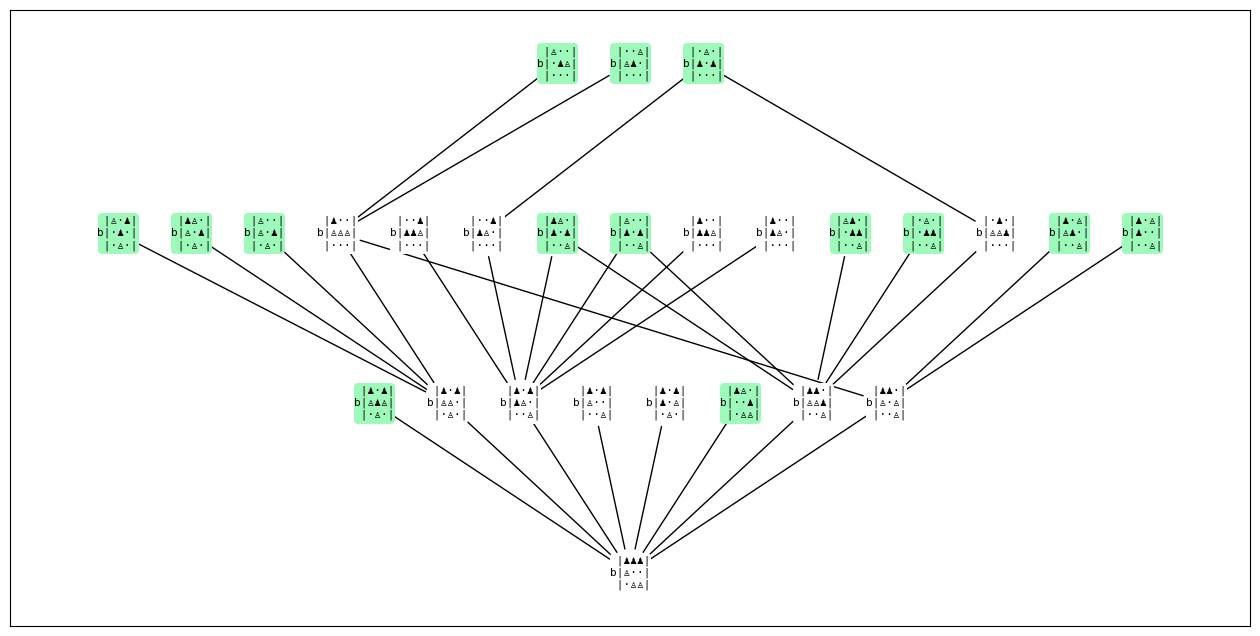

In [350]:
viz(subtrees['a1 a2'].filter_root_player())


In [351]:
# Experiments and game play

## Learning and moving

In [352]:
@dataclass
class Transition:
  """A transition in a game.
  """
  state: State
  next_state: State
  move: Move

@dataclass
class GameOutcome:
  winner: int
  transitions: list[Transition]

@dataclass
class Strategy:
  """A strategy for playing a game
  """
  tree: GameTree
  player: int

  def move(self, state: State) -> Move:
    """Return the next move for the given state.
    """
    raise NotImplementedError


@dataclass
class HexapawnBoxes(Strategy):

  def __post_init__(self):
    self.beads = {
        box:box.moves.copy()
        for box in self.tree.box_states(self.player)}

  def print_boxes(self):
    for box, moves in self.beads.items():
      print(box.render_short())
      print([str(m) for m in moves])

  def normalize_state(self, state: State) -> tuple[State, bool]:
    if state in self.beads:
      return state, False
    reflected = self.tree.reflected_state(state)
    return reflected, True

  def normalize_move(self, reflected: bool, move: Move) -> Move:
    return self.tree.reflected_move(move) if reflected else move

  def move(self, state: State) -> Move:
    """Return the next move for the given state.
    """
    norm_state, reflected = self.normalize_state(state)
    norm_move = random.choice(self.beads[norm_state])
    return self.normalize_move(reflected, norm_move)

  def train(self, outcome: GameOutcome):
    """Update the strategy based on the outcome of a game.
    """
    if outcome.winner == self.player:
      return
    for transition in reversed(outcome.transitions):
      norm_state, reflected = self.normalize_state(transition.state)
      if norm_state not in self.beads:
        continue
      norm_move = self.normalize_move(reflected, transition.move)
      if len(self.beads[norm_state]) > 1:
        self.beads[norm_state].remove(norm_move)
        break

@dataclass
class RandomStrategy(Strategy):
  """A random strategy for playing a game
  """
  def move(self, state: State) -> Move:
    return random.choice(state.moves)

@dataclass
class InteractiveStrategy(Strategy):
  """Ask user for moves.
  """
  def move(self, state: State) -> Move:
    """Get the user for a move.
    """
    def report_problem(move_str:str, issue: str):
      print(f'{issue} move "{move_str}"')
      print('your options were:', [str(m) for m in state.moves])
    move_str = input(f'{PLAYER[state.to_play]} move? ')
    try:
      move = Move.parse(move_str)
      if move not in state.moves:
        report_problem(move_str, 'illegal')
      return move
    except Exception as ex:
      report_problem(move_str, f'syntactically incorrect [{ex=}]')
    return self.input_move(state)


In [353]:
@dataclass
class Hexapawn:
  """A game of hexapawn.
  """
  tree: GameTree | None = None
  white_strategy: str = 'input'
  black_strategy: str = 'random'
  strategy: dict[int: Strategy] | None = None

  def __post_init__(self):
    if self.tree is None:
      self.tree = GameTree.rooted_at(State.initial())
    def strat(abbrev, player):
      match abbrev:
        case 'random': return RandomStrategy(self.tree, player)
        case 'input': return InteractiveStrategy(self.tree, player)
        case 'boxes': return HexapawnBoxes(self.tree, player)
        case _: raise ValueError(f'unknown strategy {abbrev}')
    self.strategy = {
        -1: strat(self.black_strategy, -1),
        +1: strat(self.white_strategy, +1),
    }

  def play(self, echo=None) -> Game:
    """Play a game of hexapawn.
    """
    if echo is None:
      echo = {'states', 'moves', 'winner'}
    state = self.tree.root
    rollout = []
    while not state.winner:
      if 'states' in echo: print('\n' + state.render_short())
      move = self.next_move(state)
      if 'moves' in echo: print(f'{PLAYER[state.to_play]} move: {move!s}')
      prev_state = state
      state = state.apply(move)
      rollout.append(Transition(state=prev_state, next_state=state, move=move))
    if 'states' in echo: print('\n' + state.render_short())
    if 'winner' in echo: print(f'{PLAYER[state.winner]} wins')
    return GameOutcome(state.winner, rollout)

  def next_move(self, state: State) -> Move | None:
    """Return the next move for the given state.
    """
    return self.strategy[state.to_play].move(state)

In [383]:
hp = Hexapawn( white_strategy='random', black_strategy='boxes')
bs = hp.strategy[-1]

def monitor():
  print('boxes', len(bs.beads))
  print('possible moves', sum([len(moves) for moves in bs.beads.values()]))
monitor()

boxes 19
possible moves 47


In [367]:
def score(n):
  score = sum([hp.play(echo=[]).winner for _ in range(n)])
  return score / n

In [384]:
score(1000)

0.216

In [386]:
for _ in range(50):
  o = hp.play(echo={'winner'})
  bs.train(o)
  monitor()
  print('score', score(1000))

black wins
boxes 19
possible moves 39
score -0.838
black wins
boxes 19
possible moves 39
score -0.878
black wins
boxes 19
possible moves 39
score -0.834
black wins
boxes 19
possible moves 39
score -0.846
black wins
boxes 19
possible moves 39
score -0.846
black wins
boxes 19
possible moves 39
score -0.844
black wins
boxes 19
possible moves 39
score -0.878
black wins
boxes 19
possible moves 39
score -0.852
black wins
boxes 19
possible moves 39
score -0.84
black wins
boxes 19
possible moves 39
score -0.832
black wins
boxes 19
possible moves 39
score -0.836
black wins
boxes 19
possible moves 39
score -0.828
black wins
boxes 19
possible moves 39
score -0.844
black wins
boxes 19
possible moves 39
score -0.852
white wins
boxes 19
possible moves 38
score -0.864
black wins
boxes 19
possible moves 38
score -0.894
black wins
boxes 19
possible moves 38
score -0.882
black wins
boxes 19
possible moves 38
score -0.878
black wins
boxes 19
possible moves 38
score -0.87
black wins
boxes 19
possible move

In [356]:
monitor()
bs.train(o)
monitor()

boxes 19
possible moves 47
boxes 19
possible moves 46


In [357]:
for _ in range(20):
  o = hp.play(echo={'winner'})
  bs.train(o)
  monitor()

white wins
boxes 19
possible moves 45
black wins
boxes 19
possible moves 45
white wins
boxes 19
possible moves 44
white wins
boxes 19
possible moves 43
black wins
boxes 19
possible moves 43
black wins
boxes 19
possible moves 43
black wins
boxes 19
possible moves 43
black wins
boxes 19
possible moves 43
black wins
boxes 19
possible moves 43
black wins
boxes 19
possible moves 43
white wins
boxes 19
possible moves 42
black wins
boxes 19
possible moves 42
black wins
boxes 19
possible moves 42
black wins
boxes 19
possible moves 42
black wins
boxes 19
possible moves 42
black wins
boxes 19
possible moves 42
black wins
boxes 19
possible moves 42
black wins
boxes 19
possible moves 42
black wins
boxes 19
possible moves 42
black wins
boxes 19
possible moves 42
